## Import classes, libraries

In [2]:
%load_ext autoreload

In [9]:
%autoreload 2
import sys
sys.path.insert(0,'..')
from src.server.db_api import connect
from src.storage.petastorm_storage_engine import PetastormStorageEngine
from src.readers.opencv_reader import OpenCVReader
from src.catalog.models.df_metadata import DataFrameMetadata
from src.storage.abstract_storage_engine import AbstractStorageEngine
from src.storage.ffmpeg_storage_engine import FFmpegStorageEngine, get_resolution, get_frame_count
from src.storage.blob_storage_engine import BlobStorageEngine
from src.catalog.models.df_column import DataFrameColumn
from src.models.storage.batch import Batch
from src.catalog.column_type import ColumnType, NdArrayType
from src.readers.abstract_reader import AbstractReader
from src.readers.petastorm_reader import PetastormReader
from typing import Iterator
import random
import os
import stat
import ffmpeg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import csv

In [126]:
## Reads video frame by frame from one location, stores it using the ffmpeg engine
# @param[in] videoname name of the video stored (physical)
# @param[in] tablename name of the table in which to store the video (logical)
# @param[in] location at which the original video is stored
# return time required to write video to storage, size of file
def writevideo_ffmpeg(videoname, tablename, video_location):
    start = time.time()
    opencv_reader = OpenCVReader(video_location, 30000000)
    resolution = get_resolution(video_location)
    ffengine = FFmpegStorageEngine()
    table = DataFrameMetadata(tablename, videoname)
    table.resolution = resolution
    ffengine.create(table)
    ffengine.open_write(table)
    for batch in opencv_reader.read():
        ffengine.write(table, batch)
    ffengine.close_write(tablename)
    end = time.time()
    
    location = ffengine._url(table)
    file_size = os.stat(location).st_size
    
    return end - start, file_size

In [129]:
def writevideo_blob(videoname, tablename, video_location):
    start = time.time()
    opencv_reader = OpenCVReader(video_location, 30000000)
    resolution = get_resolution(video_location)
    ffengine = BlobStorageEngine()
    table = DataFrameMetadata(tablename, videoname)
    table.resolution = resolution
    print(table.file_url)
    ffengine.create(table)
    ffengine.open_write(table)
    i = 0
    for batch in opencv_reader.read():
        ffengine.write(table, batch)
    ffengine.close_write(table)
    end = time.time()
    
    location = ffengine._url(table)
    video_size = sum(os.path.getsize(os.path.join(location, x)) for x in os.listdir(location))
    
    return end - start, video_size

## Video Load time
- Read video frames using OpenCVReader, and write to a "table"
- This test simulates "LOAD"

In [48]:
def writevideo_test(video_locations, video_names, writevideo):
    results = []
    
    for interval, location, name, table_name in list(zip(video_intervals, video_locations, video_names, table_names)):
        write_time, file_size = writevideo(name, table_name, location)
        results.append((name, write_time, file_size))
    
    return results

In [118]:
video_intervals_f = [1] #[1, 2, 3, 4, 6, 8, 10, 12, 14, 16]
video_locations_f = ["/home/akshay/Downloads/evavideos/" + str(x) + ".mp4" for x in video_intervals]
video_names_f = [str(x) for x in video_intervals_f]
table_names_f = ["table_" + str(x) for x in video_intervals_f]
results_ffmpeg_write = writevideo_test(video_locations_f, video_names_f, writevideo_ffmpeg)
for result in results_ffmpeg_write:
    print(result[0], result[1], result[2] / (1024 ** 2))

1 3.9687538146972656 1.6656866073608398
2 8.39613389968872 3.6601333618164062
3 9.660592079162598 5.702850341796875
4 16.653857707977295 11.265270233154297
6 23.216148614883423 16.170313835144043
8 30.601189136505127 20.450166702270508
10 33.42834973335266 23.02045726776123
12 39.45190715789795 26.660781860351562
14 62.56571435928345 29.640722274780273
16 77.87252902984619 36.603017807006836


## Video Load Time for BlobStorageEngine

In [119]:
video_intervals_b = [1, 2, 3, 4]
video_locations_b = ["/home/akshay/Downloads/evavideos/" + str(x) + ".mp4" for x in video_intervals_b]
video_names_b = [str(x) for x in video_intervals_b]
table_names_b = ["table_" + str(x) for x in video_intervals_b]
results_blob_write = writevideo_test(video_locations_b, video_names_b, writevideo_blob)
for result in results_blob_write:
    print(result[0], result[1], result[2] / (1024 ** 2))

1 2.4691083431243896 6.5076799392700195
2 5.1767737865448 16.56694793701172
3 7.50443959236145 25.010814666748047
4 12.497103452682495 42.6445255279541


## Sanity Check for Random Reads, FFmpeg

500
[0, 50, 100, 150, 200, 250, 300, 350, 400, 450]


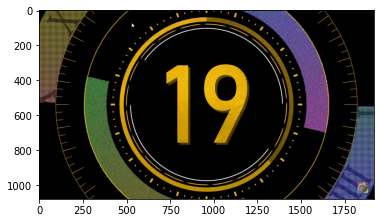

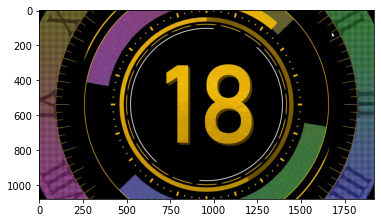

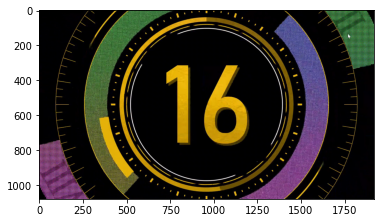

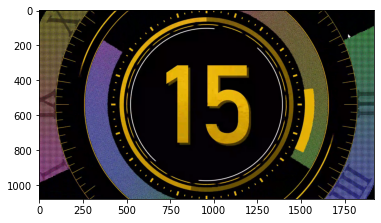

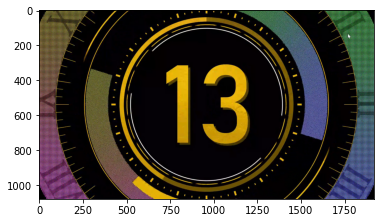

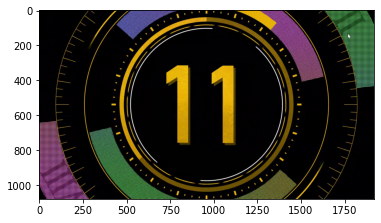

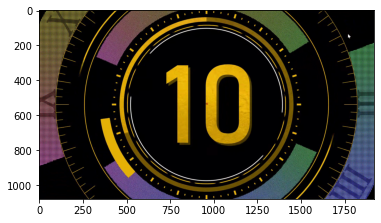

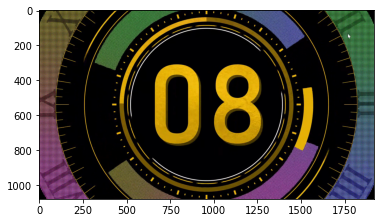

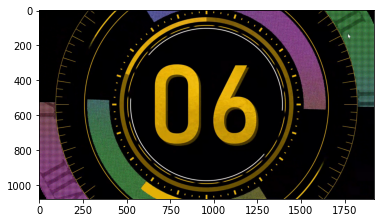

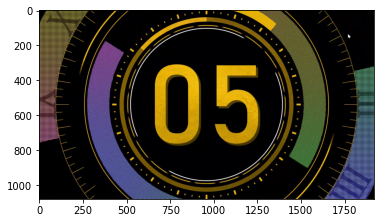

In [87]:
table = DataFrameMetadata("table_16", "16")
engine = FFmpegStorageEngine()
n_frames = engine.get_frame_count(Table)
print(n_frames)
x = False
random_frames = list(range(0, n_frames, 50))
print(random_frames)
engine.open_read(table, ("random", random_frames))
for images in engine.read(table):
    image_arrays = images.frames['data'].values
    for image in image_arrays:
        plt.imshow(image)
        plt.show()
engine.close_read(table)

## Sanity Check for Random Reads, Blob

142
[0, 50, 100]


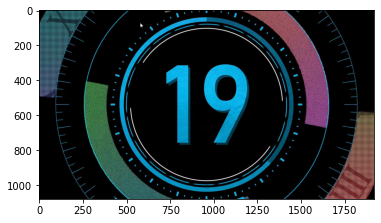

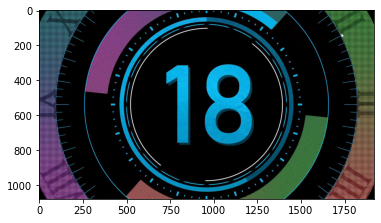

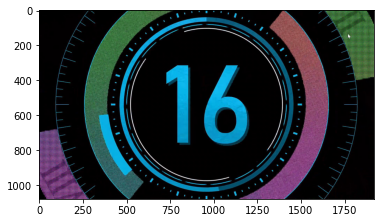

In [86]:
table = DataFrameMetadata("table_4", "4")
engine = BlobStorageEngine()
n_frames = engine.get_frame_count(table)
print(n_frames)
x = False
random_frames = list(range(0, n_frames, 50))
print(random_frames)
engine.open_read(table, ("random", random_frames))
for images in engine.read(table):
    image_arrays = images.frames['data'].values
    for image in image_arrays:
        plt.imshow(image)
        plt.show()
engine.close_read(table)

## Profiling Code

In [104]:
def sequence(start, end, step, table, Engine):
    
    ffengine = Engine()
    
    results = []
    
    for i in range(start, end, step):
        start_time = time.time()
        
        ffengine.open_read(table, ("between", (0, i)))
        for images in ffengine.read(table):
            image_arrays = images.frames['data'].values
        ffengine.close_read(table)
        
        end_time = time.time()
        
        results.append(end_time - start_time)
    
    return results

In [112]:
def random_pick(start, end, step, table, Engine):
    results = []
    ffengine = Engine()
    file_url = ffengine._url(table)
    n_frames = ffengine.get_frame_count(table)
    frames = range(n_frames)

    for i in range(start, end, step):
        start_time = time.time()
        
        ffengine.open_read(table, ("random", sorted(random.sample(frames, i))))
        for images in ffengine.read(table):
            image_arrays = images.frames['data'].values
        
        ffengine.close_read(table)
        
        end_time = time.time()
        
        results.append(end_time - start_time)
    
    return results

In [109]:
def do_test(start, end, step, testmethod, warmup_rounds, experiment_rounds, table, Engine):
    n = len(range(start, end, step))

    result_sum = [0] * n

    for i in range(warmup_rounds):
        testmethod(start, end, step, table, Engine)

    for i in range(experiment_rounds):
        test_i_results = testmethod(start, end, step, table, Engine)
        result_sum = [result_sum[i] + test_i_results[i] for i in range(n)]

    average_result = [x / experiment_rounds for x in result_sum]

    return average_result

## Expermiments

In [130]:
ten_sec_video = "/home/akshay/Downloads/evavideos/10.mp4"
#writevideo_ffmpeg("10", "table_10", ten_sec_video)
writevideo_blob("10", "table_10", ten_sec_video)

10


(25.79447364807129, 95314689)

### Sequence

In [135]:
table = DataFrameMetadata("table_10", "10")
table.resolution = (1920, 1080)
number_of_frames = FFmpegStorageEngine().get_frame_count(table)
results_f = do_test(0, number_of_frames, 30, sequence, 1, 5, table, FFmpegStorageEngine)
results_b = do_test(0, number_of_frames, 30, sequence, 1, 5, table, BlobStorageEngine)

In [137]:
for frames, extime_f, extime_b in zip(range(0, number_of_frames, 30), results_f, results_b):
    print(f"{frames} {extime_f} {extime_b}")

0 4.993561458587647 2.3889541625976563e-05
30 5.683353900909424 1.130484390258789
60 6.184449148178101 2.2801444053649904
90 6.209727191925049 3.4624492645263674
120 6.924512529373169 4.645024538040161
150 7.614277315139771 5.837544345855713
180 8.448297262191772 6.989398384094239
210 9.1632474899292 8.183889245986938
240 8.085717964172364 9.335563564300537
270 7.9275835990905765 10.47121639251709
300 9.551174736022949 11.633045482635499


### Random

In [138]:
table = DataFrameMetadata("table_10", "10")
table.resolution = (1920, 1080)
number_of_frames = FFmpegStorageEngine().get_frame_count(table)
results_rand_f = do_test(0, number_of_frames, 30, random_pick, 1, 5, table, FFmpegStorageEngine)
results_rand_b = do_test(0, number_of_frames, 30, random_pick, 1, 5, table, BlobStorageEngine)

In [140]:
for frames, extime_f, extime_b in zip(range(0, number_of_frames, 30), results_rand_f, results_rand_b):
    print(f"{frames} {extime_f} {extime_b}")

0 11.953676986694337 3.495216369628906e-05
30 4.691419267654419 1.1691374778747559
60 7.8345554828643795 2.3628787994384766
90 9.320273542404175 3.520142936706543
120 10.37453203201294 4.7162816524505615
150 11.444178533554076 5.889299583435059
180 10.721969890594483 7.041360235214233
210 11.37089400291443 8.15329909324646
240 12.665416812896728 9.36285719871521
270 13.552596282958984 10.460730791091919
300 14.579015254974365 11.795108318328857


## Stress Test, Random N Frames, with replacement

In [52]:
random_results = do_test(50, 500, 50, random_n, 1, 2, table)
for frames, rtime in zip(range(0, 500, 50), random_results):
    print(f"{frames} {rtime}")

50 50
100 100
150 150
200 200
250 250
300 300
350 350
400 400
450 450
50 50
100 100
150 150
200 200
250 250
300 300
350 350
400 400
450 450
50 50
100 100
150 150
200 200
250 250
300 300
350 350
400 400
450 450
0 7.712672829627991
50 6.65441370010376
100 7.360141396522522
150 8.54240095615387
200 9.016069054603577
250 9.82991111278534
300 11.331424593925476
350 14.278607368469238
400 13.918431639671326


In [83]:
video_intervals = [1, 2, 3, 4, 6, 8, 10, 12, 14, 16]
video_locations = ["/home/akshay/Downloads/evavideos/" + str(x) + ".mp4" for x in video_intervals]
video_names = [str(x) for x in video_intervals]
table_names = ["table_" + str(x) for x in video_intervals]

In [96]:
def video_test_point_query():
    results = []
    number_of_frames = []
    for video, table_name in zip(video_names, table_names):
        table = DataFrameMetadata(table_name, video)
        #print(ffengine._url(table))
        n_frames = int(ffmpeg.probe(ffengine._url(table) + ".mp4")['streams'][0]['nb_frames'])
        print(n_frames)
        frame = random.randrange(n_frames)
        table.resolution = (1920, 1280)
        start_time = time.time()
        ffengine.open_read(table, ("random", [frame]))
        for images in ffengine.read(table):
            image_arrays = images.frames['data'].values
        ffengine.close_read(table)
        end_time = time.time()    
        number_of_frames.append(n_frames)
        results.append(end_time - start_time)
    return number_of_frames, results

In [97]:
sum_results = [0] * len(video_intervals)
print(sum_results)
frames, results_across_videos = video_test()
for i in range(3):
    _, results_i = video_test()
    sum_results = [sum_results[i] + results_i[i] for i in range(len(video_intervals))]
    
avg_results = [x / 3 for x in sum_results]
print(avg_results)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
27
60
89
142
202
266
308
371
423
500
27
60
89
142
202
266
308
371
423
500
27
60
89
142
202
266
308
371
423
500
27
60
89
142
202
266
308
371
423
500
[0.4550052483876546, 0.7183191776275635, 0.941396951675415, 1.5469048817952473, 2.0835627714792886, 2.599161942799886, 2.9492828051249185, 3.4326114654541016, 3.898787260055542, 4.691850105921428]


In [99]:
print(results_across_results)
frame_counts = [x[0] for x in results_across_results]

[(27, 0.6908631324768066), (60, 0.7625288963317871), (89, 0.9750816822052002), (142, 1.5520527362823486), (202, 2.125415325164795), (266, 2.568614959716797), (308, 2.91607403755188), (371, 3.6731321811676025), (423, 4.455996751785278), (500, 4.980330228805542)]


In [100]:
for frames, avg_time in zip(frame_counts, avg_results):
    print(f"{frames},{avg_time}")

27,0.4550052483876546
60,0.7183191776275635
89,0.941396951675415
142,1.5469048817952473
202,2.0835627714792886
266,2.599161942799886
308,2.9492828051249185
371,3.4326114654541016
423,3.898787260055542
500,4.691850105921428


In [103]:
def video_test_range_query():
    results = []
    number_of_frames = []
    for video, table_name in zip(video_names, table_names):
        table = DataFrameMetadata(table_name, video)
        #print(ffengine._file_url(table))
        n_frames = int(ffmpeg.probe(ffengine._url(table) + ".mp4")['streams'][0]['nb_frames'])
        print(n_frames)
        frame = random.randrange(n_frames)
        table.resolution = (1920, 1280)
        start_time = time.time()
        ffengine.open_read(table, ("between", (frame, frame + 10)))
        for images in ffengine.read(table):
            image_arrays = images.frames['data'].values
        ffengine.close_read(table)
        end_time = time.time()    
        number_of_frames.append(n_frames)
        results.append(end_time - start_time)
    return number_of_frames, results

In [104]:
sum_results_range = [0] * len(video_intervals)
for i in range(3):
    _, results_i = video_test_range_query()
    sum_results_range = [sum_results_range[i] + results_i[i] for i in range(len(video_intervals))]
    
avg_results_range = [x / 3 for x in sum_results]
print(avg_results_range)

27
60
89
142
202
266
308
371
423
500
27
60
89
142
202
266
308
371
423
500
27
60
89
142
202
266
308
371
423
500
[0.4550052483876546, 0.7183191776275635, 0.941396951675415, 1.5469048817952473, 2.0835627714792886, 2.599161942799886, 2.9492828051249185, 3.4326114654541016, 3.898787260055542, 4.691850105921428]


In [106]:
avg_results_range = [x / 3 for x in sum_results_range]

for frames, avg_time in zip(frame_counts, avg_results_range):
    print(f"{frames},{avg_time}")

27,1.040590524673462
60,1.2731739679972331
89,1.4530449708302815
142,2.000558296839396
202,2.712224324544271
266,3.692084868748983
308,3.9504953225453696
371,4.230886061986287
423,4.654622395833333
500,5.613044500350952
